# Realestate Analysis

**A deep look into the realestate pricing in...***

## Donload Dependancies

In [89]:
import os
import tarfile
import urllib
from zlib import crc32

## Saving Models
import joblib

## Data Visualisation and Manipulation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix                   # Scatter Correlation plots
plt.style.use('dark_background')
%matplotlib inline

## Data Preparation
from sklearn.pipeline import Pipeline                        # Automating transformations
from sklearn.impute import SimpleImputer                     # To impute numerical features 
from sklearn.compose import ColumnTransformer                # Automating transformations on columns
from sklearn.preprocessing import OneHotEncoder              # To binary encode catagorical features
from sklearn.preprocessing import OrdinalEncoder             # To encode catagorical features
from sklearn.preprocessing import StandardScaler             # Scaling. Numerical features using pipeline
from sklearn.model_selection import train_test_split         # Split data into train and test set
from sklearn.model_selection import StratifiedShuffleSplit   # Stratified Sampling
from sklearn.base import BaseEstimator, TransformerMixin     # Custom Transformers

## Model Building
from sklearn.svm import SVR                                  # Support Vector Machine Regressor
from sklearn.metrics import mean_squared_error               # Metric to test model performance
from sklearn.tree import DecisionTreeRegressor               # A more powerful model
from sklearn.linear_model import LinearRegression            # Our baseline model 
from sklearn.ensemble import RandomForestRegressor           # Ensemble of Decision Trees
from sklearn.model_selection import cross_val_score          # Cross-Validation
from sklearn.model_selection import GridSearchCV             # Grid Search Cross-Validation
from sklearn.model_selection import RandomizedSearchCV       # Randomised Grid Search

## Model Evaluation
from scipy import stats                                      # Used for sumarising Statistics

<h1>
    <span style="color:yellow">
    Data Collection
    </span>
</h1>

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
# Fetches data from a specified url. Extracts and saves data to specified path
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
# Call fetch so download data
fetch_housing_data()

In [5]:
# Loads data set from a specified directory
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

<h1>
    <span style="color:yellow">
    Sumarise Data
    </span>
</h1>

Let us begine by sumarising the infoormation in our dataset.

We have 10 feature in our raw data.

In [6]:
# Load data set to variable
housing = load_housing_data()

# Preview data
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

There are a total of 20640 intance in our data, and all our entries apear to be continouse numerical values with the exception of ```ocean_proximity```.

In [7]:
# Rundown of data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We can also see the distribution of the numerical features.

In [8]:
# Basic data distribution
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

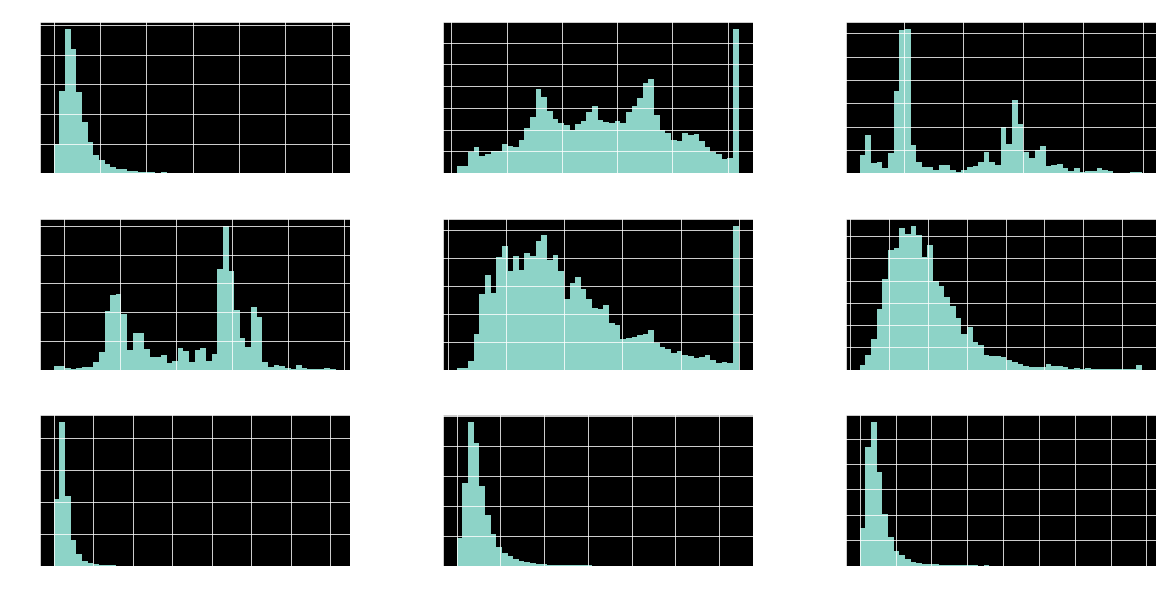

In [9]:
# Plot histogrames of the Numerical variables
housing.hist(bins=50, figsize=(20,10))
plt.show()

As we can see above many features tail-heavy and some features (namely ```mean_income```) apear to have been scaled down. However, other features have not. This will likely cause scaling issues for our model, so it may be suitable to rescale (normalise) oour input using:

$$
X_{normed} = \frac{X_{original} - \mu}{\sigma}
$$

where $\mu$ is the mean and $\sigma$ is the variance:

$$
\mu = \sum{X_{original}},\space\space \sigma^{2} = \sum{(X_{original} - \mu)}
$$

Let us take a look at the distribution of the classes in the catagorical columns (i.e. ```ocean_proximity```).

In [10]:
# Count occurances for each catagory in ocean_proximity
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

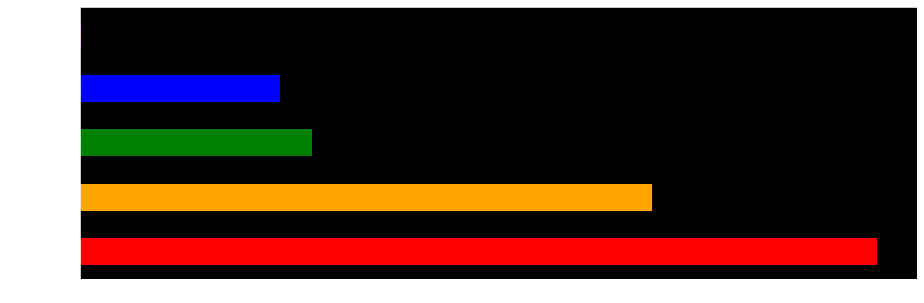

In [11]:
# Plot a barchart of the catagorical variables
housing.ocean_proximity.value_counts().sort_values(ascending=False).plot(
    kind='barh',
    color=['red','orange','green','blue','purple'],
    figsize=(15,5)
)

plt.show()

<h1>
    <span style="color:yellow">
    Train Test Split
    </span>
</h1>

Before progressing with our analysis we will seperate our data into our training and testing sets. To do this we will create a  ```train_test_split()``` sunction that will seperate our data into some specified ratio.

In [12]:
# Seperate given data into a training and testing set
def my_train_test_split(data, test_ratio=0.2, seed=0):
    # Set randome seed
    np.random.seed(seed)
    
    # Randome permutation of data indeces
    shuffeld_index = np.random.permutation(len(data))
    
    # Preposion which is test set
    test_size = int(len(data) * test_ratio)
    test_index = shuffeld_index[:test_size]
    
    # Remaining is train set
    train_index = shuffeld_index[test_size:]
    
    return data.iloc[train_index], data.iloc[test_index]

In [13]:
# Create a train test split on housing data
train, test = my_train_test_split(housing)

print("Our Training set has a total of {} examples".format(len(train)))
print("Our Testing set has a total of {} examples".format(len(test)))

Our Training set has a total of 16512 examples
Our Testing set has a total of 4128 examples


Unfortunately if the dataset is updated our random ordering will be changed. To overcome this we can use hashing from the ```zlib``` library. We can create a function that uses the row index as a unique identifier, to create a Hashing for our data.

In [14]:
# Identifies if the hashing ID is intestset
def my_test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio*2**32

# Split train test based on hash ID
def my_train_test_split_by_id(data, id_column, test_ratio=0.2):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: my_test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
# Reset indexes for housing data
housing_with_id = housing.reset_index()

# Split into train and test based on ID
train, test = my_train_test_split_by_id(housing_with_id, "index")

Nex we have tto make sure that any new entries added to our data is appended to the end of our dataset and that no row ever gets deleted.

However, this can become problematic so lets engineer a more stable feature. Using the unique ```latitude``` and ```longitude``` features for a given entry, we can combine these values with our hashing function to create a more stable identifier for each entry. This idea assumes there are:

1. There are no repeated entries in our data.
2. No two districts have the same latitude and lingitude.

In [16]:
# Create a new index column called id
housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]

# Use new indexing to hash data
train, test = my_train_test_split_by_id(housing_with_id, "id")

A far simpler option is to use Sklearns ```train_test_spli()``` function.

In [17]:
# Using sklear's model_selection library
train, test = train_test_split(housing, test_size=0.2, random_state=0)

In order to ensure our  training data is a fair representation of the envirument we are modeling for, we can create stratum (catagories) of income. 

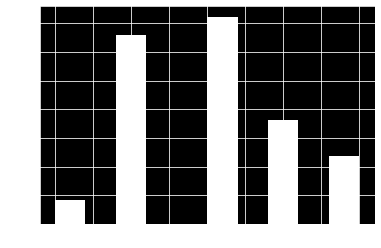

In [18]:
# Create a new catagorical variable: stratums of incomoe
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])

# Plot histogram of stratums
housing["income_cat"].hist(color="w")
plt.show()

To do stratified sampling: sampling from homogenouse subsets of a population (stratums) to generate a fairly representative sample; we can. use Scikit-learn's ```StratifiedShuffleSplit``` class.

In [19]:
# Creates an stratified indexing object 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# Using the indexes to split housing data into sample that represeent the overall data
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train = housing.loc[train_index]
    strat_test = housing.loc[test_index]

In [20]:
# Take a look at the frequencies in each set
print("Test set:\n---------\n{}".format(strat_test["income_cat"].value_counts() / len(strat_test))) # Test set
print("\nTrain set:\n----------\n{}".format(strat_train["income_cat"].value_counts() / len(strat_train))) # Train set

Test set:
--------
 3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

Train set:
--------
 3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64


Next we must remove the ```income_cat``` column we engineered.

In [21]:
for set_ in (strat_train, strat_test):
    set_.drop("income_cat", axis=1, inplace=True)
    for col in set_.columns:
        print(col)
    print("\n")

longitude
latitude
housing_median_age
total_rooms
total_bedrooms
population
households
median_income
median_house_value
ocean_proximity


longitude
latitude
housing_median_age
total_rooms
total_bedrooms
population
households
median_income
median_house_value
ocean_proximity




<h1>
    <span style="color:yellow">
    Data Exploration
    </span>
</h1>

To enssure we do not interfier with the test set, we will rename the train set, "```housing```" and operate only on this set.

In [22]:
# Copy training data
housing = strat_train.copy()

### Geospatial Analysis

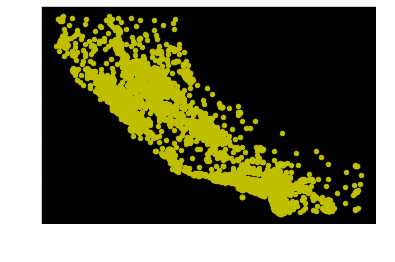

In [23]:
# Plot housing location
housing.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", 
    color="y"
)

plt.show()

Let transparancy replect frequency

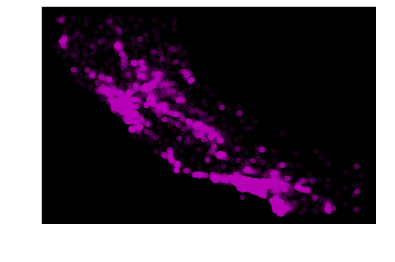

In [24]:
# Plot housing location with transparancy
housing.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", 
    alpha=0.1, 
    color="m"
)

plt.show()

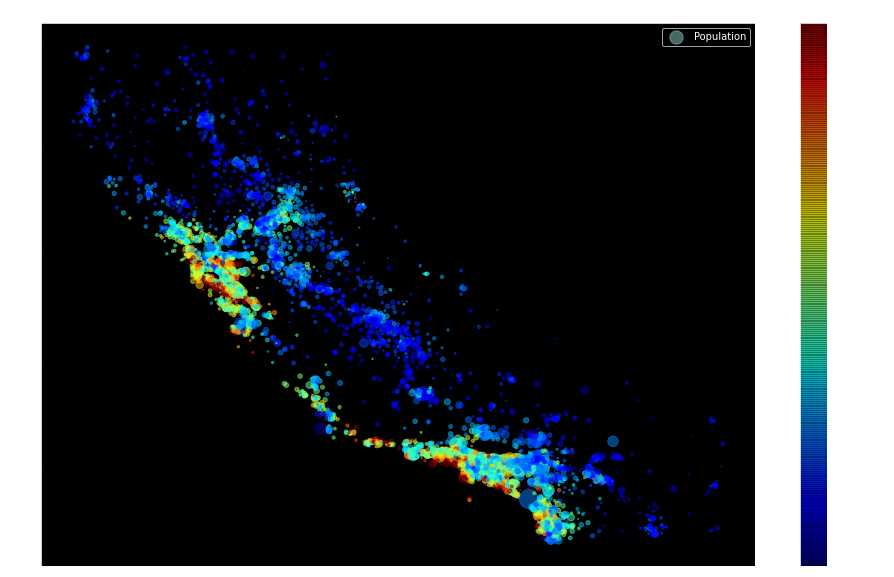

In [25]:
# A better plot
housing.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", alpha=0.5,
    s=housing["population"]/100, 
    label="Population", 
    figsize=(16,10),
    c="median_house_value", 
    cmap=plt.get_cmap("jet"), 
    colorbar=True
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Califoonia House Prices")
plt.legend()
plt.show()

We can calculate the standard correlation coefficient (Pearson's r) between every pair of attributes.

In [26]:
# Generate correlation matrix
corr_matrix = housing.corr()

# Display Pearson's r for median_house_value
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688883
total_rooms           0.137469
housing_median_age    0.107144
households            0.069177
total_bedrooms        0.053544
population           -0.023797
longitude            -0.043236
latitude             -0.145570
Name: median_house_value, dtype: float64

Selecting atrributes that have strong correlation with ```median_hoouse_value``` we can use pandas ```scatter_matrix()``` plot to illustrate pairwise correlation of the selected features.

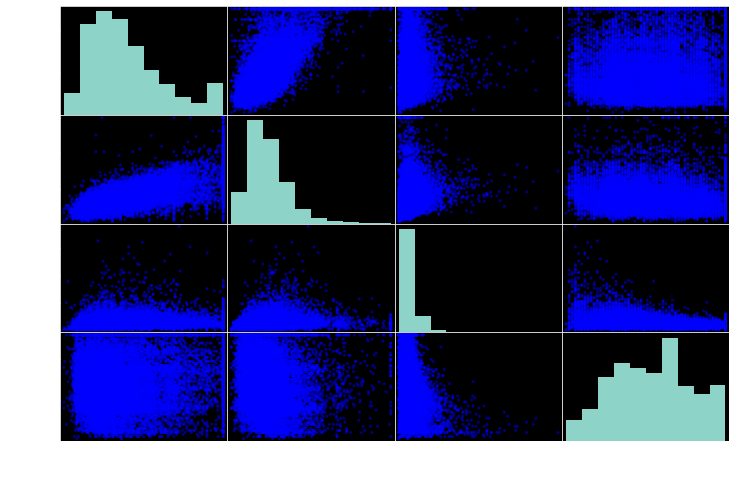

In [27]:
# Specify attributes
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

# Create plots
scatter_matrix(housing[attributes], figsize=(12,8), color="b")

plt.show()

We can see that there is a noticable possitive corelation between the median income of a district and the median housing price.

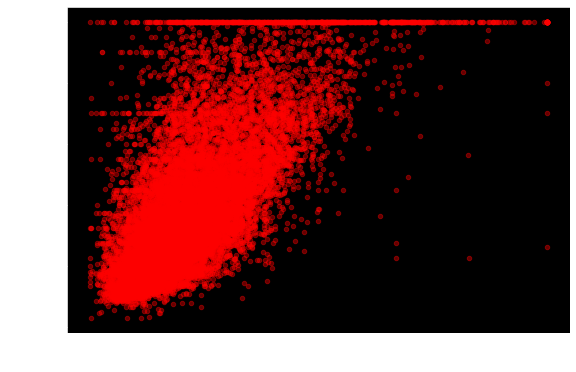

In [28]:
# Plot median_income against meadian_house_value
housing.plot(
    kind="scatter", 
    x="median_income", 
    y="median_house_value", 
    c="r", 
    alpha=0.4, 
    figsize=(9,6)
)

plt.show()

1. We can see a stroong possitive correlation with fairly low dispersion.
2. There is clearly a cap of house prices at \$500,000 - apears artificial.
3. Moore of these artificial line apear at: \$450,000, 350,000, and 280,000.

<h1>
    <span style="color:yellow">
    Feature Engineering
    </span>
</h1>

Combining multiple features in a relevant manner to improve our model perfomance.

In [29]:
# The average number of rooms per house for a dsistrict
housing["rooms_per_households"] = housing["total_rooms"] / housing["households"]

# The average number of rooms per house for a dsistrict
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]

# The average number of rooms per house for a dsistrict
housing["population_per_households"] = housing["population"] / housing["households"]

# Group attributes under variable name extra_atributes 
extra_atributes = ["rooms_per_households", "bedrooms_per_room", "population_per_households"]

Now we can illustrate the correlattion between house price andour new features.

In [30]:
corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value           1.000000
median_income                0.688883
rooms_per_households         0.157620
total_rooms                  0.137469
housing_median_age           0.107144
households                   0.069177
total_bedrooms               0.053544
population                  -0.023797
population_per_households   -0.026888
longitude                   -0.043236
latitude                    -0.145570
bedrooms_per_room           -0.255870
Name: median_house_value, dtype: float64

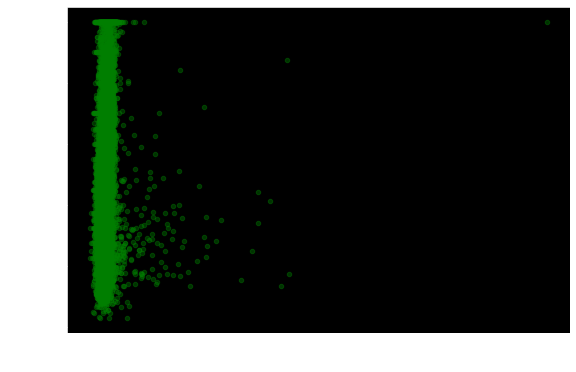

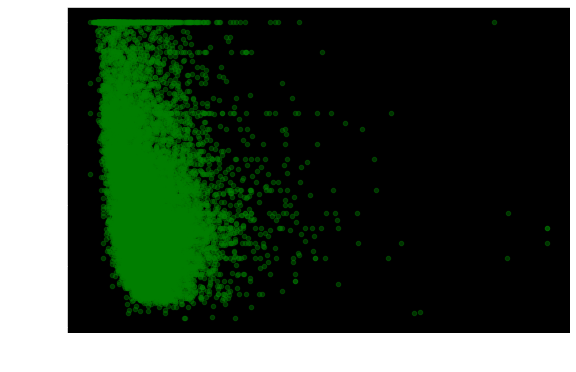

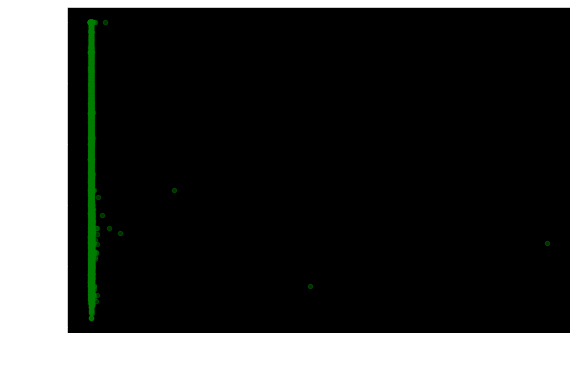

In [31]:
# Chosen attributes
attributes = ["rooms_per_households", "bedrooms_per_room", "population_per_households"]

for attribute in attributes:
    housing.plot(kind="scatter", x=attribute, y="median_house_value", c="g", alpha=0.4, figsize=(9,6))
    plt.show()

<h1>
    <span style="color:yellow">
    Data Preparation
    </span>
</h1>

We will creatte a functioon to clean and process our data so we can re-use it for future datasets.

In [32]:
# Revert housing data to the predictive features original training set
housing = strat_train.drop("median_house_value", axis=1)

# Collect the corresponding target features foor housing data
housing_labels = strat_train["median_house_value"].copy()

### Numerical Features

For missing values in the numerical features of our training data we can choose to:
* Drop examples missing feature: `housing.dropna(subset=["total_bedrooms"])`
* Drop feature for all examples: `housing.drop("total_bedrooms", axis=1)`
* Replace missing valuse: 
```python
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)
```

In [33]:
# Calculate feature median and Save value
median = housing["total_bedrooms"].median()

# Impute median value
housing["total_bedrooms"].fillna(median, inplace=True)

Next use tensorflows `SimpleImputer` to impute any other missing values.

In [34]:
# Create an median impute instance
imputer = SimpleImputer(strategy='median')

Apply imputer ONLY to numerical features. As `ocean_proximity` is the only catagorical featture, we will drop that column.

In [35]:
# Numerical features
housing_num = housing.drop("ocean_proximity", axis=1)

housing_num.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
10275    -117.87     33.86                28.0       2292.0           531.0   
20601    -121.57     39.13                30.0        442.0           103.0   
20138    -119.05     34.40                50.0       1236.0           282.0   
18028    -121.94     37.24                35.0       1484.0           244.0   
16289    -121.30     37.92                28.0       3308.0           766.0   

       population  households  median_income  
10275      2197.0       509.0         3.4856  
20601       413.0        88.0         1.5694  
20138      1079.0       257.0         2.6991  
18028       664.0       238.0         4.6750  
16289      3201.0       720.0         1.7694

Apply imputer.

In [36]:
# fit imputer to numerical data
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [37]:
print("Imputers values: ", imputer.statistics_.tolist())
print("Numerical columns: ", housing_num.median().values.tolist())

Imputers values:  [-118.49, 34.25, 29.0, 2128.5, 436.0, 1167.0, 410.0, 3.5341]
Numerical columns:  [-118.49, 34.25, 29.0, 2128.5, 436.0, 1167.0, 410.0, 3.5341]


Replace missing values in numerical columns with the mean imputer.

In [38]:
# Saturate Numerical data with the transform method
X = imputer.transform(housing_num)

In [39]:
X

array([[-1.1787e+02,  3.3860e+01,  2.8000e+01, ...,  2.1970e+03,
         5.0900e+02,  3.4856e+00],
       [-1.2157e+02,  3.9130e+01,  3.0000e+01, ...,  4.1300e+02,
         8.8000e+01,  1.5694e+00],
       [-1.1905e+02,  3.4400e+01,  5.0000e+01, ...,  1.0790e+03,
         2.5700e+02,  2.6991e+00],
       ...,
       [-1.1830e+02,  3.4250e+01,  4.4000e+01, ...,  8.5900e+02,
         2.9200e+02,  4.5833e+00],
       [-1.2191e+02,  3.7310e+01,  4.6000e+01, ...,  1.3730e+03,
         5.9000e+02,  4.7287e+00],
       [-1.1830e+02,  3.4090e+01,  2.9000e+01, ...,  3.9060e+03,
         1.1020e+03,  2.1927e+00]])

Note top fit the data and then transform it symultaniously we could have used Tensorflows `fit_transform()` method.

X is currently just an array. To revert the data back to a numpy dataframe we do the following:

In [40]:
# Create dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [41]:
housing_tr.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
10275    -117.87     33.86                28.0       2292.0           531.0   
20601    -121.57     39.13                30.0        442.0           103.0   
20138    -119.05     34.40                50.0       1236.0           282.0   
18028    -121.94     37.24                35.0       1484.0           244.0   
16289    -121.30     37.92                28.0       3308.0           766.0   

       population  households  median_income  
10275      2197.0       509.0         3.4856  
20601       413.0        88.0         1.5694  
20138      1079.0       257.0         2.6991  
18028       664.0       238.0         4.6750  
16289      3201.0       720.0         1.7694

### Catagorical Features

In [42]:
# Catagorical Features
housing_cat = housing[["ocean_proximity"]]

housing_cat.head()

ocean_proximity
10275       <1H OCEAN
20601          INLAND
20138       <1H OCEAN
18028       <1H OCEAN
16289          INLAND

Using Tensorflows `OrdinalEncoder`.

In [43]:
# Create encoder 
ordinal_encoder = OrdinalEncoder()

# Fit and transform catagorical variables to encodings
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

# Display Encoding
housing_cat_encoded

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [44]:
# Catagories of encoding
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

This encoding may not be viable as the magnitude of the numerical values may be interprited by the algorithm as holding value. So we can instead use a "OneHot Encoder":  `OneHotEncoder`. We'll create the encoder, fit it and then transform the data.

In [45]:
# Create OneHotEncoding instance
cat_encoder = OneHotEncoder()

# Fit and transform catagorical features
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

# Display
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [46]:
# Diaplay array
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [47]:
# Catagories of OneHotEncodings
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

<h1>
    <span style="color:yellow">
    Custume Feature Enginearing
    </span>
</h1>

In [48]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [49]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Calculate rooms in a house
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        # Calculate average populationo
        population_per_household = X[:, population_ix] / X[:, households_ix]
        # Add new attributes
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [50]:
# Create a Transformer that creates new attributes
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
# Create new attributes
housing_extra_attribs = attr_adder.transform(housing.values)

housing_extra_attribs

array([[-117.87, 33.86, 28.0, ..., '<1H OCEAN', 4.50294695481336,
        4.31630648330059],
       [-121.57, 39.13, 30.0, ..., 'INLAND', 5.0227272727272725,
        4.693181818181818],
       [-119.05, 34.4, 50.0, ..., '<1H OCEAN', 4.809338521400778,
        4.198443579766537],
       ...,
       [-118.3, 34.25, 44.0, ..., '<1H OCEAN', 4.938356164383562,
        2.941780821917808],
       [-121.91, 37.31, 46.0, ..., '<1H OCEAN', 5.172881355932203,
        2.3271186440677964],
       [-118.3, 34.09, 29.0, ..., '<1H OCEAN', 2.9446460980036298,
        3.544464609800363]], dtype=object)

We will use Scikit-learn `Pipeline` class to autimate data transformation.

In [51]:
# Create pipeline to automate transform numerical data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

In [52]:
# Transform numerical data
housing_num_tr = num_pipeline.fit_transform(housing_num)

housing_num_tr

array([[ 0.84450121, -0.82473693, -0.04853356, ..., -0.38320306,
         0.11361593,  0.28225234],
       [-1.00168564,  1.64070891,  0.11081943, ..., -0.16739639,
         0.14811788,  0.30367359],
       [ 0.25571729, -0.5721106 ,  1.70434932, ..., -0.25599289,
         0.10282589,  0.22665626],
       ...,
       [ 0.62994436, -0.64228458,  1.22629035, ..., -0.20242628,
        -0.0122183 , -0.25527205],
       [-1.17133524,  0.78926462,  1.38564334, ..., -0.10505418,
        -0.06848902, -0.33912717],
       [ 0.62994436, -0.71713683,  0.03114293, ..., -1.03019125,
         0.04295583,  2.41512989]])

To automate the transformation process for both numerical and catagorical data type simultaniously we can use the `ColumnTransformer` class.

In [53]:
# list of numerical and catagorical column names
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

In [54]:
# Create Pipeline process for all columns
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

In [55]:
# Call transformer on data
housing_prepared = full_pipeline.fit_transform(housing)

housing_prepared

array([[ 0.84450121, -0.82473693, -0.04853356, ...,  0.        ,
         0.        ,  0.        ],
       [-1.00168564,  1.64070891,  0.11081943, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.25571729, -0.5721106 ,  1.70434932, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.62994436, -0.64228458,  1.22629035, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17133524,  0.78926462,  1.38564334, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.62994436, -0.71713683,  0.03114293, ...,  0.        ,
         0.        ,  0.        ]])

In [56]:
housing_prepared[0]

array([ 0.84450121, -0.82473693, -0.04853356, -0.15631878, -0.01220643,
        0.67606966,  0.02634094, -0.20234886, -0.38320306,  0.11361593,
        0.28225234,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

<h1>
    <span style="color:Yellow">
    Model Selection
    </span>
</h1>
    
## Linear Regression

In [57]:
# Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(
    housing_prepared, 
    housing_labels
)

LinearRegression()

In [58]:
# Let take 'some' data points to test model perfomance
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

# Prepate some data
some_data_prepared = full_pipeline.transform(some_data)

# Make some predictions
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [172713.58885788  43130.16935351 195014.22158132 268919.62476372
  44875.4698183 ]
Labels: [142800.0, 57900.0, 181300.0, 245300.0, 73900.0]


In [59]:
# Calculate RMSE (randome mean squared error) oof our Linear Regression model
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(
    housing_labels, 
    housing_predictions
)

lin_rmse = np.sqrt(lin_mse)
lin_rmse

68284.24083518104

As the majority of houses lie between 120,000 and 265,000 -- 68,000 is a fairly large disparity. This may be do to a lack of information being fed to our model. Alternatevely we may infact need a more powerful model.

## Decision Tree Regressor

In [60]:
# Decision Trees
tree_reg = DecisionTreeRegressor()
tree_reg.fit(
    housing_prepared, 
    housing_labels
)

DecisionTreeRegressor()

In [61]:
# Calculate RMSE on data
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(
    housing_labels, 
    housing_predictions
)

tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

<h2>Support Vector Machine Regressor</h2>

In [94]:
# SVM regressor
svm_reg = SVR()
svm_reg.fit(
    housing_prepared,
    housing_labels
)

SVR()

In [96]:
# Calculate RMSE on data
housing_preds_svm = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(
    housing_labels,
    housing_preds_svm
)

svm_rmse = np.sqrt(svm_mse)
svm_rmse

118292.97659943995

In [93]:
help(svm_reg)

Help on SVR in module sklearn.svm._classes object:

class SVR(sklearn.base.RegressorMixin, sklearn.svm._base.BaseLibSVM)
 |  SVR(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
 |  
 |  Epsilon-Support Vector Regression.
 |  
 |  The free parameters in the model are C and epsilon.
 |  
 |  The implementation is based on libsvm. The fit time complexity
 |  is more than quadratic with the number of samples which makes it hard
 |  to scale to datasets with more than a couple of 10000 samples. For large
 |  datasets consider using :class:`sklearn.svm.LinearSVR` or
 |  :class:`sklearn.linear_model.SGDRegressor` instead, possibly after a
 |  :class:`sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  Read more in the :ref:`User Guide <svm_regression>`.
 |  
 |  Parameters
 |  ----------
 |  kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf'
 |       Specifies the 

<h1>
    <span style="color:yellow">
    Cross-Validattion
    </span>
</h1>

We will use Scikitt-Learn's "K-folds" cross-validation feature(`cross_val_score`), which will randomly divide our data into "K" distinct folds. Thesefoldswill be used to iteratively train and evaluate the Decision Tree model: 10 times.

In [62]:
scores = cross_val_score(
    tree_reg, 
    housing_prepared, 
    y=housing_labels, 
    scoring='neg_mean_squared_error', 
    cv=10
)

tree_rmse_scores = np.sqrt(-scores)

In [63]:
def display_scores(scores):
    print("\nScores:", scores)
    print("\nMean:", scores.mean())
    print("\nStandard Deviation:", scores.std())

In [64]:
display_scores(tree_rmse_scores)


Scores: [70162.32030596 73677.79838172 70982.98313438 70854.05621542
 69600.44871852 68626.85785509 73643.36118371 73008.09102743
 68000.15170227 69480.51328796]

Mean: 70803.65818124461

Standard Deviation: 1934.5972329117556


### Do the same for the Linear Regression Model

In [65]:
lin_scores = cross_val_score(
    lin_reg, 
    housing_prepared, 
    y=housing_labels, 
    scoring='neg_mean_squared_error', 
    cv=10
)

lin_rmse_scores = np.sqrt(-lin_scores)

In [66]:
display_scores(lin_rmse_scores)


Scores: [68816.92050905 69919.6105217  66113.14067776 67981.42224765
 68715.57149727 69992.34941025 67163.97848562 70841.91062928
 66611.37068257 68651.01821515]

Mean: 68480.72928763037

Standard Deviation: 1456.394289447671


We can see from the above results that the Dessiosion Tree overfits

## Random Forest Regressor

In [67]:
# Create the regressor
forest_reg = RandomForestRegressor()
forest_reg.fit(
    housing_prepared, 
    housing_labels
)

RandomForestRegressor()

In [68]:
def rmse_cv_scores(esstimator, cv, name=None):
    # Returns RMSE of an estimator using cross-validation with cv folds
    predictions = esstimator.predict(housing_prepared)
    mse = mean_squared_error(housing_labels, predictions)
    rmse = np.sqrt(mse)
    
    scores = cross_val_score(
        esstimator, 
        housing_prepared, 
        y=housing_labels, 
        scoring='neg_mean_squared_error', 
        cv=cv
    )
    
    rmse_scores = np.sqrt(-scores)
    if name:
        print("{} RMSE: {}".format(name, rmse))
        print("--------------")
        
    print("Cross-Validation Scores:")
    display_scores(rmse_scores)
    
    return rmse, rmse_scores

In [69]:
forest_rmse, forest_rmse_scores = rmse_cv_scores(
    forest_reg, 
    10, 
    name="Random Forest"
)

Random Forest RMSE: 18604.194911538478
--------------
Cross-Validation Scores:

Scores: [49673.09665189 53174.22166486 48198.96000415 50056.48260906
 51074.19916858 48291.16422773 49440.34971524 51657.60305677
 50434.07199872 51848.96927989]

Mean: 50384.91183768834

Standard Deviation: 1506.3166627224878


<h1>
    <span style="color:yellow">
    Fine-Tune Your Model
    </span>
</h1>

<h2>Saving Multiple Models</h2>

In [70]:
# Saving models
def save_model(model, name):
    print("-----------------------------------")
    print("Saving {} ...".format(name))
    print("-----------------------------------\n")
    joblib.dump(model, name + ".pkl")

In [71]:
# Dictionary of existing models
models = {
    "Random_Forest_Regressor": forest_reg,
    "Decision_Tree_Regressor": tree_reg,
    "Linear_Regression_Model": lin_reg
}

In [72]:
"""
for model_name in models:
    save_model(models[model_name], model_name)
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(wandb.run.dir, "model.ckpt"))
"""

'\nfor model_name in models:\n    save_model(models[model_name], model_name)\n    saver = tf.train.Saver()\n    saver.save(sess, os.path.join(wandb.run.dir, "model.ckpt"))\n'

<h2>
    Grid Search
</h2>

In [73]:
# Hyper-parameters grid search
param_grid = [
    {
        'n_estimators': [3, 10, 30], 
        'max_features': [2, 4, 6, 8]
    },
    {
        'bootstrap': [False], 
        'n_estimators': [3, 10], 
        'max_features': [2, 3, 4]
    }
]

# Create the regressor
forest_reg = RandomForestRegressor()

In [74]:
# Grid Search
grid_search = GridSearchCV(
    forest_reg, 
    param_grid, 
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search.fit(
    housing_prepared, 
    housing_labels
)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

To get the best combinations of hyper-parameters, we can use the ```best_params_``` method like so:

In [75]:
# Get best parameters
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

As 6 and 30 were the larges values within their resprective parameters, a suitable sujestion would be to try large values for our parameters.

Alternatively, we can get the best estimators directly.

In [76]:
# Best estimators
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [77]:
# Evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

65021.21109946404 {'max_features': 2, 'n_estimators': 3}
55195.12344464695 {'max_features': 2, 'n_estimators': 10}
53303.30697249522 {'max_features': 2, 'n_estimators': 30}
60637.1105446736 {'max_features': 4, 'n_estimators': 3}
52932.65428310139 {'max_features': 4, 'n_estimators': 10}
50713.50199936942 {'max_features': 4, 'n_estimators': 30}
59766.17186653358 {'max_features': 6, 'n_estimators': 3}
52181.997307082805 {'max_features': 6, 'n_estimators': 10}
49853.2889937385 {'max_features': 6, 'n_estimators': 30}
58431.6293168216 {'max_features': 8, 'n_estimators': 3}
52586.16669722744 {'max_features': 8, 'n_estimators': 10}
50322.62634449812 {'max_features': 8, 'n_estimators': 30}
63130.653262646236 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54679.36362904365 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60290.02261278914 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52732.50125800016 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}

When hyper-parameter search spaces is large its more practical to use a Random Grid Search method.

> With hyper-parameters (max_features = 6 and n_estimators = 30) we get error = 49,853.

We can also use determin feature importance for random forest models.

In [78]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.09238841e-02, 6.42833578e-02, 4.25994113e-02, 1.84115904e-02,
       1.60145258e-02, 1.74009712e-02, 1.65904886e-02, 3.51179019e-01,
       6.31933365e-02, 1.04617820e-01, 6.42922141e-02, 1.23821165e-02,
       1.51848585e-01, 1.04213310e-04, 2.20500784e-03, 3.95345836e-03])

Displaying the feature importance beside the corresponding feature.

In [80]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])

all_attribs = num_attribs + attributes + cat_one_hot_attribs
sorted(zip(feature_importances, all_attribs), reverse=True)

[(0.35117901927358136, 'median_income'),
 (0.15184858511746416, 'INLAND'),
 (0.10461781968879616, 'bedrooms_per_room'),
 (0.0709238841205685, 'longitude'),
 (0.06429221407042549, 'population_per_households'),
 (0.06428335780716063, 'latitude'),
 (0.06319333650459649, 'rooms_per_households'),
 (0.042599411317074634, 'housing_median_age'),
 (0.01841159040162379, 'total_rooms'),
 (0.017400971217563246, 'population'),
 (0.016590488640857572, 'households'),
 (0.016014525839824576, 'total_bedrooms'),
 (0.012382116492405764, '<1H OCEAN'),
 (0.003953458356310837, 'NEAR OCEAN'),
 (0.0022050078418477505, 'NEAR BAY'),
 (0.00010421330989907835, 'ISLAND')]

Impolication: 
> Only one ocean_proximity category is really useful, so you could try dropping the others

<h2>Evaluating System on Test Set</h2>

In [83]:
# Final Model
final_model = grid_search.best_estimator_

# Features and Targets
X_test = strat_test.drop("median_house_value", axis=1)
Y_test = strat_test["median_house_value"].copy()

# Pass Features through Pipeline
X_test_prepared = full_pipeline.transform(X_test)

# Make predicton
final_predictions = final_model.predict(X_test_prepared)

# Calculate Error
final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 

print("Mean Squared Error: {}".format(final_rmse))

Mean Squared Error: 48642.97334623934


To get a judge of how precise the estimates are, we can compute the confidence intervels for the gemeral errors using the ```scipy.stats.t.interval()``` function.

In [88]:
# Set confidence interval
confidence = .95

# Calculate Squared Error
squared_errors = (final_predictions - Y_test) ** 2

# Calculate the resulting interval
interval = np.sqrt(
    stats.t.interval(
        confidence, 
        len(squared_errors) - 1,
        loc=squared_errors.mean(),
        scale=stats.sem(squared_errors)
    )
)

# Display
print("{} < x < {}".format(interval[0], interval[1]))

46471.28227281784 < x < 50721.766884109726


Now comes the project prelaunch phase: you need to present your solution (highlighting what you have learned, what worked and what did not, what assumptions were made, and what your system’s limitations are), document everything, and create nice presentations with **clear visualizations and easy-to-remember statements** (e.g., *“the median income is the number one predictor of housing prices”*). 

In this California housing example, the final performance of the system is not better than the experts’ price estimates, which were often off by about 20%, but it may still be a good idea to launch it, especially if this frees up some time for the experts so they can work on more interesting and productive tasks.

Ways to deploy model to production:
- Save model including preprocessing and prediction pipline. Load model into production envirument.
- Wrap model with dedicated webserver. Then application can make queries through REST API.
- Deploy model onto a cloud web server. Application can then make request in Jason format.

Write monitoring code:
- Checks for system performance. 
- Check in regular intervals as defult.
- Create drop trigger alerts for model faliure.
- Check for model decay or data rot, (e.g. model accuracy).
- Use down stream metrics to measure perfomence (e.g. user retention). 
- Check for changes in useres seaches, (e.g. location, image format/ qulity).

Have back ups of your model.